In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC,SVC

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os            ##  This module is for "operating system" interfaces
import sys           ##  This module is for functionality relevant to the python run time

GOOGLE_PATH_AFTER_MYDRIVE = 'NLP_Textcat/spooky_data/train'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive', GOOGLE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Append the directory path of this notebook to what python easily "sees"
sys.path.append(GOOGLE_DRIVE_PATH)

# Make your current working direct
GOOGLE_DRIVE_PATH

['train.csv']


'drive/My Drive/NLP_Textcat/spooky_data/train'

In [4]:
df = pd.read_csv('drive/My Drive/NLP_Textcat/spooky_data/train/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:

X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [6]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X)

max_features = 1000000
Vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', ngrams=2)
with tf.device('/device:CPU:0'):
  Vectorizer.adapt(X)

vocab = encoder.get_vocabulary()

In [7]:
class CNN1d(tf.keras.Model):
    def __init__(self, conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder):
        super(CNN1d, self).__init__()

        self.encoder = encoder

        vocab = encoder.get_vocabulary()
        
        self.embedding = tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True)
        

        self.conv1 = tf.keras.layers.Conv1D(filters=conv1_filters,
                            kernel_size=conv1_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.conv2 = tf.keras.layers.Conv1D(filters=conv2_filters,
                            kernel_size=conv2_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.global_pool = tf.keras.layers.GlobalMaxPool1D(keepdims=False)
        self.dense1 = tf.keras.layers.Dense(dense1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, x, training=False):
        emb = self.encoder(x)
        emb = self.embedding(emb)
        conv1 = self.conv1(emb)
        conv2 = self.conv2(emb)
        z = tf.concat([conv1, conv2], axis=2)
        z = self.global_pool(z)
        z = self.dense1(z)
        z = self.dense2(z)
        return z

In [8]:
def create_model(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1):
    model = CNN1d(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy']
    )
    return model

def create_ngram():
    model_ngram = tf.keras.Sequential()
    model_ngram.add(Vectorizer)
      
    model_ngram.add(tf.keras.layers.Dense(25, activation='relu'))
    model_ngram.add(tf.keras.layers.Dropout(0.2))
      
    model_ngram.add(tf.keras.layers.Dense(3, activation='softmax'))
      
    model_ngram.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
    return model_ngram

def create_lstm():
    LSTM = tf.keras.Sequential()
    LSTM.add(encoder)
    LSTM.add(tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True))
      
    LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2,return_sequences=True)))
    LSTM.add(tf.keras.layers.GlobalMaxPool1D())

    LSTM.add(tf.keras.layers.Dropout(0.2))
      
    LSTM.add(tf.keras.layers.Dense(3, activation='softmax'))
      
    LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
    
    return LSTM

def create_ensemble():
    ensemble = tf.keras.Sequential()
    # for 3 model
    ensemble.add(tf.keras.layers.Dense(36, activation='relu'))
    ensemble.add(tf.keras.layers.Dropout(0.2))

    ensemble.add(tf.keras.layers.Dense(3, activation='softmax'))
    #ensemble.add(tf.keras.layers.InputLayer())

    ensemble.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])

    return ensemble


In [9]:
max_features = 1000000
tfidf_vec = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', sparse=True, ngrams=2)

with tf.device('/device:CPU:0'):
  tfidf_vec.adapt(X)

tdidf = tf.keras.Sequential([
    tfidf_vec])

In [10]:
df = pd.DataFrame(columns = ['model', 'average', 'logloss'])
df

,model,average,logloss


In [11]:
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):

  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]


    
  x_train_sparce = tdidf.predict(X_train)
  x_test_sparce = tdidf.predict(X_test)




  cnn = create_model(128, 6, 128, 5, 128)
  ngram = create_ngram()
  LSTM = create_lstm()
  ensemble = create_ensemble()
  ensemble_with_tdidf = create_ensemble()

  cnn.fit(X_train, y_train, epochs=1 )

  ngram.fit(X_train, y_train, epochs=1, batch_size=64)
  
  LSTM.fit(X_train, y_train, epochs=2, batch_size=64)
  

  cnn_pred = cnn.predict(X_train)
  ngram_pred = ngram.predict(X_train)
  LSTM_pred = LSTM.predict(X_train)

  cnn_pred_test = cnn.predict(X_test)
  ngram_pred_test = ngram.predict(X_test)
  LSTM_pred_test = LSTM.predict(X_test)


  X_train_ens = np.hstack([ngram_pred,cnn_pred,LSTM_pred])
  X_test_ens = np.hstack([ngram_pred_test,cnn_pred_test,LSTM_pred_test])

  X_train_final_tensor = tf.sparse.from_dense(X_train_ens)
  X_test_final_tensor = tf.sparse.from_dense(X_test_ens)
  X_train_concat_tensor = tf.sparse.concat(1,[x_train_sparce, X_train_final_tensor])
  X_test_concat_tensor = tf.sparse.concat(1,[x_test_sparce, X_test_final_tensor])


  ensemble.fit(X_train_ens, y_train, epochs=2, batch_size=128)
  ensemble_with_tdidf.fit(X_train_concat_tensor, y_train, epochs=1, batch_size=256)

  ngram_results = ngram.evaluate(X_test,y_test)
  LSTM_results =LSTM.evaluate(X_test,y_test)
  cnn_results =cnn.evaluate(X_test,y_test)
  ensemble_results =ensemble.evaluate(X_test_ens,y_test)
  ensemble_with_tdidf_results =ensemble_with_tdidf.evaluate(X_test_concat_tensor,y_test)



  lin_reg = LinearRegression(fit_intercept=False, positive= True)
  lin_reg.fit(X_train_ens, y_train)
  linreg_logloss = log_loss(y_test,lin_reg.predict(X_test_ens))
  linreg_acc = np.sum(np.argmax(y_test, axis = 1) == np.argmax(lin_reg.predict(X_test_ens), axis = 1))/len(np.argmax(y_test, axis = 1))


  lin_reg2 = LinearRegression(fit_intercept=False, positive= True)
  lin_reg2.fit(np.hstack((X_train_ens,ensemble_with_tdidf.predict(X_train_concat_tensor))), y_train)
  linreg2_logloss = log_loss(y_test,lin_reg2.predict(np.hstack((X_test_ens,ensemble_with_tdidf.predict(X_test_concat_tensor)
  ))))
  linreg2_acc = np.sum(np.argmax(y_test, axis = 1) == np.argmax(lin_reg2.predict(np.hstack((X_test_ens,ensemble_with_tdidf.predict(X_test_concat_tensor)
  ))), axis = 1))/len(np.argmax(y_test, axis = 1))


  df_results = pd.DataFrame({"model":['ngram', 'cnn', 'LSTM','ensemble','ensemble_tdidf','lin_reg_1','lin_reg_2'],\
                  "average":[ngram_results[1],cnn_results[1],LSTM_results[1],ensemble_results[1],ensemble_with_tdidf_results[1],\
                             linreg_acc, linreg2_acc],\
                  "logloss":[ngram_results[0],cnn_results[0],LSTM_results[0],ensemble_results[0],ensemble_with_tdidf_results[0],\
                             linreg_logloss, linreg2_logloss]})

  df = df.append(df_results)


276/276 [==============================] - 31s 109ms/step - loss: 0.5440 - accuracy: 0.7808
Epoch 1/2
276/276 [==============================] - 66s 209ms/step - loss: 0.7617 - accuracy: 0.6550
Epoch 2/2
276/276 [==============================] - 59s 213ms/step - loss: 0.3012 - accuracy: 0.8884
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.4811 - accuracy: 0.9103
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_7/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_7/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_7/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 108ms/step - loss: 0.5421 - accuracy: 0.7794
Epoch 1/2
276/276 [==============================] - 66s 210ms/step - loss: 0.7436 - accuracy: 0.6676
Epoch 2/2
276/276 [==============================] - 57s 207ms/step - loss: 0.2901 - accuracy: 0.8934
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.8632
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_8/dense_16/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_8/dense_16/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_8/dense_16/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 31s 110ms/step - loss: 0.5428 - accuracy: 0.7833
Epoch 1/2
276/276 [==============================] - 65s 201ms/step - loss: 0.7590 - accuracy: 0.6624
Epoch 2/2
276/276 [==============================] - 56s 204ms/step - loss: 0.3044 - accuracy: 0.8897
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.6324 - accuracy: 0.8142
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_12/dense_25/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_12/dense_25/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_12/dense_25/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 108ms/step - loss: 0.5511 - accuracy: 0.7805
Epoch 1/2
276/276 [==============================] - 67s 211ms/step - loss: 0.7783 - accuracy: 0.6475
Epoch 2/2
276/276 [==============================] - 58s 210ms/step - loss: 0.3064 - accuracy: 0.8875
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.4741 - accuracy: 0.9450
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1075 - accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_16/dense_34/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_16/dense_34/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_16/dense_34/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 108ms/step - loss: 0.5509 - accuracy: 0.7805
Epoch 1/2
276/276 [==============================] - 66s 207ms/step - loss: 0.7383 - accuracy: 0.6700
Epoch 2/2
276/276 [==============================] - 57s 206ms/step - loss: 0.2905 - accuracy: 0.8943
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.5621 - accuracy: 0.8885
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9860


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_20/dense_43/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_20/dense_43/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_20/dense_43/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 107ms/step - loss: 0.5378 - accuracy: 0.7873
Epoch 1/2
276/276 [==============================] - 67s 211ms/step - loss: 0.7685 - accuracy: 0.6497
Epoch 2/2
276/276 [==============================] - 58s 211ms/step - loss: 0.3044 - accuracy: 0.8909
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.5928 - accuracy: 0.8694
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.9865


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_24/dense_52/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_24/dense_52/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_24/dense_52/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 107ms/step - loss: 0.5399 - accuracy: 0.7847
Epoch 1/2
276/276 [==============================] - 66s 209ms/step - loss: 0.7442 - accuracy: 0.6699
Epoch 2/2
276/276 [==============================] - 57s 208ms/step - loss: 0.2873 - accuracy: 0.8955
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.6013 - accuracy: 0.8237
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9850


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_28/dense_61/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_28/dense_61/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_28/dense_61/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 30s 108ms/step - loss: 0.5545 - accuracy: 0.7796
Epoch 1/2
276/276 [==============================] - 67s 213ms/step - loss: 0.7491 - accuracy: 0.6666
Epoch 2/2
276/276 [==============================] - 58s 212ms/step - loss: 0.2940 - accuracy: 0.8939
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.5468 - accuracy: 0.8721
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1209 - accuracy: 0.9838


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_32/dense_70/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_32/dense_70/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_32/dense_70/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 31s 109ms/step - loss: 0.5277 - accuracy: 0.7912
Epoch 1/2
276/276 [==============================] - 66s 213ms/step - loss: 0.7463 - accuracy: 0.6611
Epoch 2/2
276/276 [==============================] - 59s 212ms/step - loss: 0.2818 - accuracy: 0.8957
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.5505 - accuracy: 0.8701
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9850


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


276/276 [==============================] - 31s 109ms/step - loss: 0.5343 - accuracy: 0.7822
Epoch 1/2
276/276 [==============================] - 68s 213ms/step - loss: 0.7518 - accuracy: 0.6646
Epoch 2/2
276/276 [==============================] - 59s 213ms/step - loss: 0.3041 - accuracy: 0.8880
Epoch 1/2
138/138 [==============================] - 1s 2ms/step - loss: 0.6230 - accuracy: 0.8353
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.1308 - accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_40/dense_88/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_40/dense_88/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_40/dense_88/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


62/62 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8646


In [12]:
df.groupby('model').describe()

average                      ...   logloss                    
                 count      mean       std  ...       50%       75%       max
model                                       ...                              
LSTM              10.0  0.835845  0.006681  ...  0.435471  0.440643  0.468366
cnn               10.0  0.825732  0.007066  ...  0.440789  0.448356  0.459085
ensemble          10.0  0.865826  0.006271  ...  0.365570  0.378712  0.385331
ensemble_tdidf    10.0  0.869860  0.004480  ...  0.344938  0.348617  0.359730
lin_reg_1         10.0  0.856938  0.006826  ...  0.368880  0.376489  0.384315
lin_reg_2         10.0  0.870167  0.004518  ...  0.341282  0.343294  0.355336
ngram             10.0  0.856479  0.006849  ...  0.370010  0.376938  0.385483

[7 rows x 16 columns]

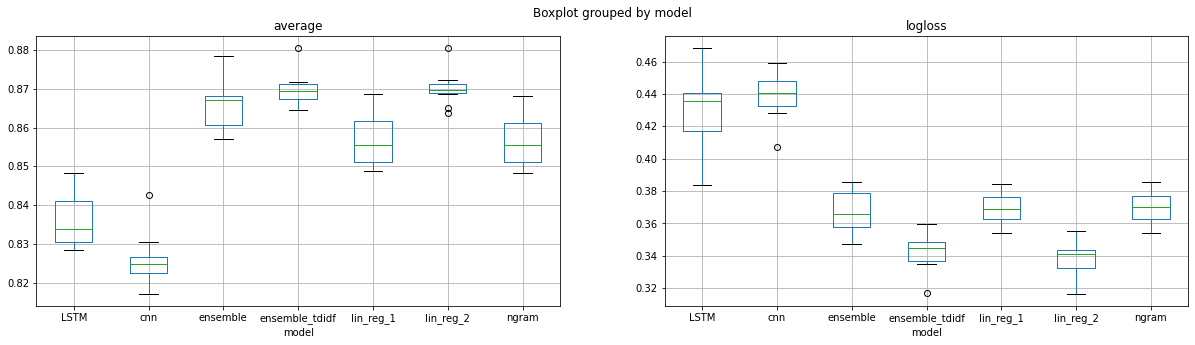

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

df.boxplot('average',by = 'model', ax=ax[0])
df.boxplot('logloss',by = 'model', ax=ax[1])


plt.show()